In [1]:
import os

from hydra import compose, initialize
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import cartopy.crs as ccrs

## Metrics 

In [13]:
def avg_monthly(ds, *args):
    return ds.resample(time="1ME").mean()


def get_above_quantile_days(ds, quantile_ds):
    return (ds > quantile_ds).resample(time="1ME").sum()


def avg_hot_day_intensity(ds, quantile_ds):
    intense_day_mask = (ds > quantile_ds).astype(int)

    masked_days = ds * intense_day_mask

    return masked_days.resample(time="1ME").mean()


def get_above_quantile_streak(ds, quantile_ds):
    def compute_streak(ds):
        """Helper function to compute the streak of a dataset"""
        intense_days = (ds > quantile_ds).astype(int)
        # Keep track of the consecutive days
        streak = intense_days.isel(time=0)

        # Cumulative sum of the streak
        for day in intense_days.time:
            streak = (streak * intense_days.sel(time=day)) + 1

        # Account for the duplicate first day
        streak -= 1
        return streak

    return ds.resample(time="1ME").map(compute_streak)


def get_wet_days(ds, *args):
    return (ds > 1).resample(time="1ME").sum()


METRIC_FN_DICT = {
    "tas": [
        avg_monthly,
        get_above_quantile_days,
        avg_hot_day_intensity,
        get_above_quantile_streak,
    ],
    "pr": [avg_monthly, get_wet_days],
}

METRIC_NAMES_DICT = {
    "tas": [
        "Average Monthly Temperature",
        "Days Above 90th Percentile",
        "Average Temperature on Days Above 90th Percentile",
        "Average Hot Streak",
    ],
    "pr": [
        "Average Monthly Precipitation",
        "Wet Days",
        "Consecutive Days Above 90th Quantile",
    ],
}

METRIC_HIST_AXES = {
    "tas": [
        np.linspace(-1.5, 1.5, 40),
        np.linspace(-2, 2, 40),
        np.linspace(-1.5, 1.5, 40),
        np.linspace(-1.5, 1.5, 40),
    ],
    "pr": [
        np.linspace(-1.5, 1.5, 40),
        np.linspace(-2, 2, 40),
        np.linspace(-1.5, 1.5, 40),
        np.linspace(-1.5, 1.5, 40),
    ],
}

CMAPS = {"tas": "bwr", "pr": "BrBG"}

## Loading Data

In [14]:
with initialize(version_base=None, config_path="../configs"):
    cfg = compose(config_name="data_viz")

# Construct the path to the saved data
data_path = os.path.join(cfg.paths.save_dir, cfg.esm, cfg.scenario)

# Construct the file names for the gen/val/test files
gen_prefix = cfg.gen_prefix + "_" if cfg.gen_prefix is not None else ""

gen_file = f"gen_{cfg.var}_{gen_prefix}{cfg.start_year}-{cfg.end_year}.nc"
val_file = f"val_{cfg.var}_{cfg.start_year}-{cfg.end_year}.nc"
test_file = f"test_{cfg.var}_{cfg.start_year}-{cfg.end_year}.nc"

# Open up the datasets
gen_set = xr.open_dataset(os.path.join(data_path, gen_file))[cfg.var]
val_set = xr.open_dataset(os.path.join(data_path, val_file))[cfg.var]
test_set = xr.open_dataset(os.path.join(data_path, test_file))[cfg.var]


# Load the quantile data
quantile_path = os.path.join(cfg.paths.quantile_dir, cfg.esm, cfg.var + "_90.nc")
quantile_ds = xr.open_dataset(quantile_path)[cfg.var]

## Generating Metric Visualizations

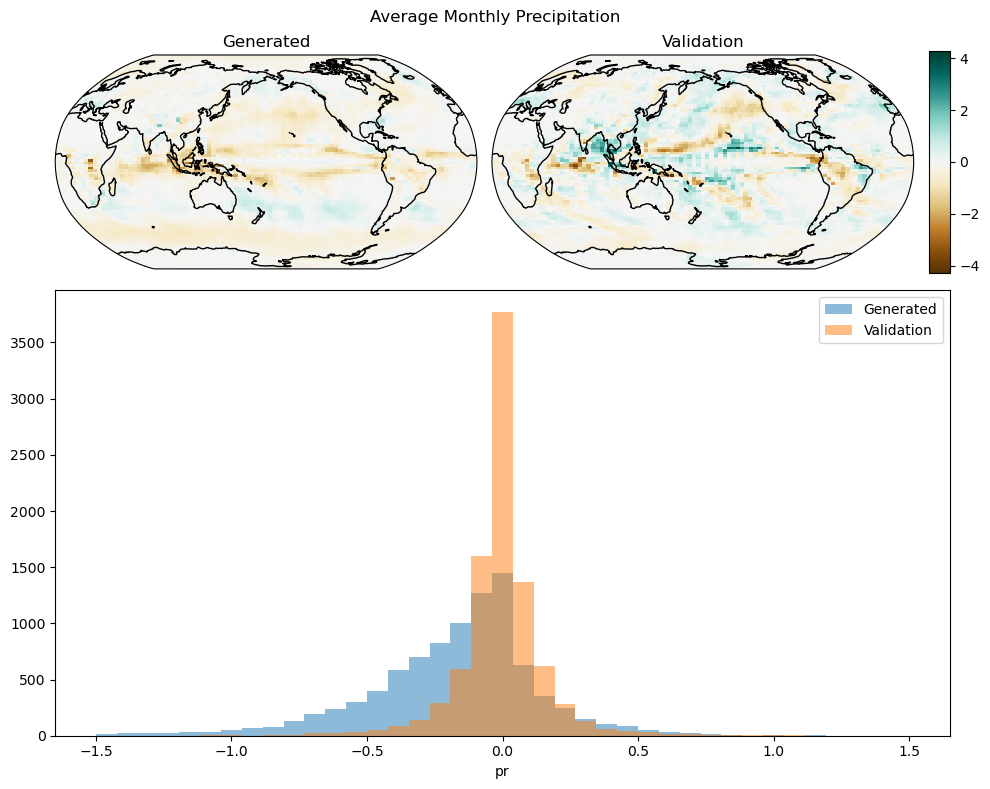

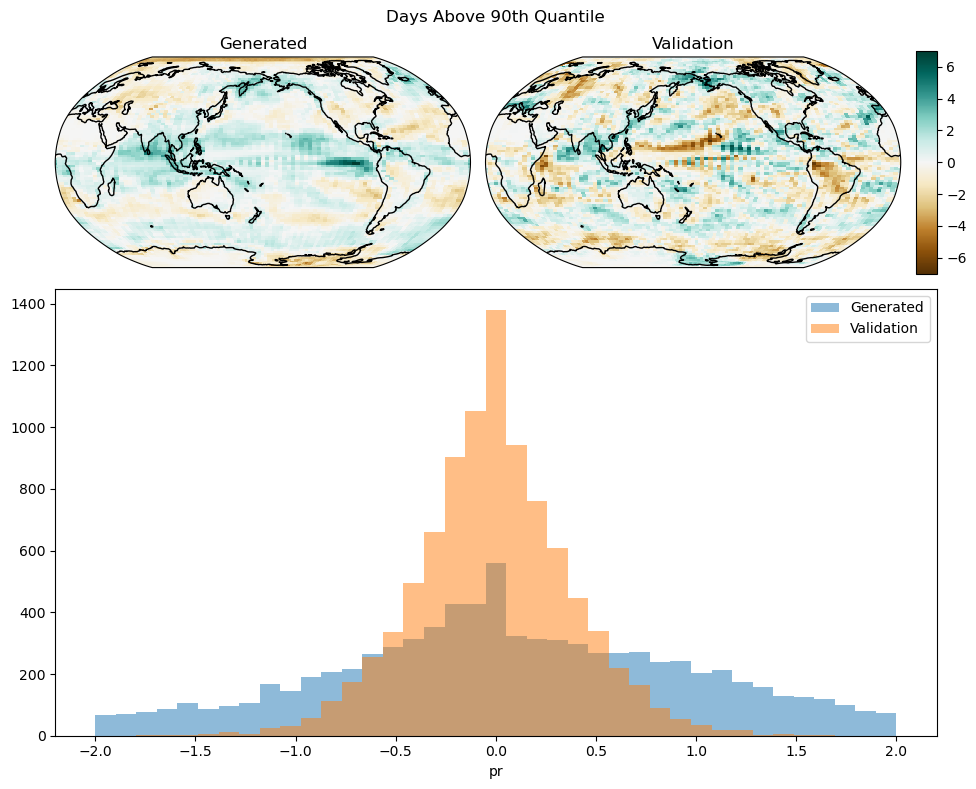

In [15]:
var = cfg.var
cmap = CMAPS[var]

# Iterate through every metric, the name, and the xaxis limits
for metric, name, bin_range in zip(
    METRIC_FN_DICT[var], METRIC_NAMES_DICT[var], METRIC_HIST_AXES[var]
):
    # Calculate the metric for each of the generated / validation / test sets
    gen_results = metric(gen_set, quantile_ds)
    val_results = metric(val_set, quantile_ds)
    test_results = metric(test_set, quantile_ds)

    # Calculate the difference between the gen/val/test sets
    gen_diff = (gen_results - test_results).mean(dim="time")
    val_diff = (val_results - test_results).mean(dim="time")

    fig = plt.figure(figsize=(10, 8))

    # Setup the grid layout - Make the colorbar axis very narrow
    gs = gridspec.GridSpec(2, 3, height_ratios=[1, 2], width_ratios=[1, 1, 0.05])

    # Create the subplots
    ax1 = plt.subplot(
        gs[0, 0], projection=ccrs.Robinson(central_longitude=180)
    )  # First plot in the first row
    ax2 = plt.subplot(
        gs[0, 1], projection=ccrs.Robinson(central_longitude=180)
    )  # Second plot in the first row
    ax3 = plt.subplot(gs[1, :])  # Third plot in the second row spanning all columns

    cbar_ax = plt.subplot(gs[0, 2])  # Colorbar in the first row, third column

    # Save the generated difference to use in the colorbar
    a = gen_diff.plot(
        ax=ax1, cmap=cmap, add_colorbar=False, transform=ccrs.PlateCarree()
    )
    val_diff.plot(ax=ax2, cmap=cmap, add_colorbar=False, transform=ccrs.PlateCarree())

    # Add coastlines to the maps
    ax1.coastlines()
    ax2.coastlines()

    # Title each axis
    ax1.set_title("Generated")
    ax2.set_title("Validation")

    # Plot the histograms
    gen_diff.plot.hist(ax=ax3, bins=bin_range, alpha=0.5, label="Generated")
    val_diff.plot.hist(ax=ax3, bins=bin_range, alpha=0.5, label="Validation")
    ax3.legend()

    fig.colorbar(a, cax=cbar_ax, orientation="vertical")
    # Add a title to the figure
    fig.suptitle(name)

    plt.tight_layout()

(array([       0.,        0.,        0.,        0.,        0.,        0.,
               0.,        0.,        0.,        0.,        0.,        0.,
               0.,        0.,        0.,        0.,        0.,        0.,
               0., 15710685.,  2411990.,  1722138.,  1431032.,  1255655.,
         1139382.,  1070869.,  1019352.,   985010.,   967895.,   955926.,
          951037.,   948970.,   951127.,   952201.,   945159.,   940769.,
          920509.,   900922.,   872326.]),
 array([-1.        , -0.94871795, -0.8974359 , -0.84615385, -0.79487179,
        -0.74358974, -0.69230769, -0.64102564, -0.58974359, -0.53846154,
        -0.48717949, -0.43589744, -0.38461538, -0.33333333, -0.28205128,
        -0.23076923, -0.17948718, -0.12820513, -0.07692308, -0.02564103,
         0.02564103,  0.07692308,  0.12820513,  0.17948718,  0.23076923,
         0.28205128,  0.33333333,  0.38461538,  0.43589744,  0.48717949,
         0.53846154,  0.58974359,  0.64102564,  0.69230769,  0.74358974,
  

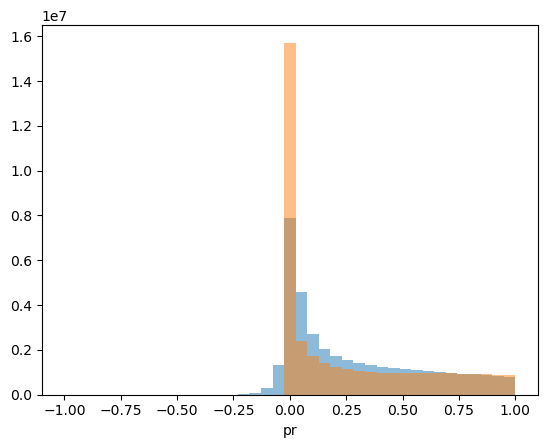

In [19]:
gen_set.plot.hist(bins=np.linspace(-1, 1, 40), alpha=0.5, label="Generated")

val_set.plot.hist(bins=np.linspace(-1, 1, 40), alpha=0.5, label="Generated")